# Setup Environment

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import time
import datetime
from transformers import AutoModel, AutoTokenizer
device = torch.device("cuda:0")

# Support Functions

In [2]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval based on the magnitude of the total iterations.

    Parameters:
      `total_iters`         - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the course of the for-loop.
    '''

    # Divide the total iterations by the desired number of updates. Most likely this will be some ugly number.
    exact_interval = total_iters / num_desired_updates;

    # The `round` function has the ability to round down a number to, e.g., the nearest thousandth: round(exact_interval, -3).
    # To determine the magnitude to round to, find the magnitude of the total, and then go one magnitude below that.

    # (1) Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1;

    # (2) Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1;

    # (3) Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag));

    # Don't allow the interval to be zero!
    if update_interval == 0: update_interval = 1;

    return update_interval

In [3]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [4]:
def make_smart_batches(text_samples, text_ids, batch_size, max_len):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples.
    print('Tokenizing {:,} samples...'.format(len(text_ids)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_ids), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                     add_special_tokens=True, # Do add specials.
                                     max_length=max_len,      # Do Truncate!
                                     truncation=True,         # Do Truncate!
                                     padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0
                and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = 0

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)

# Data

In [5]:
tweets = pd.read_csv(os.getcwd()[:os.getcwd().index("SENTICOIN")] + "SENTICOIN/data/processed/models/regression/loader/corpus/arrays/final/clean_text.csv")
tweets = tweets.dropna(); tweets[:10]

,id,clean_text
0,1.0,_ recording the future _ wire less _ deattache...
1,2.0,____ <CN FT> Giveaway ____ Artwork no: <number...
2,3.0,____ <CN FT> hidden auction ____ Artwork no: <...
3,4.0,_____ is over priced/under featured Compared t...
4,5.0,_.+=:{|[ Becker ]|}:=+._ @user Alex Becker has...
5,6.0,_atmosfear_ is entering series <number> . Seri...
6,7.0,_dwight_schrute_ has bought Mars Cat < <number...
7,8.0,_Ghoul has bought Mars Cat < <number> > from Z...
8,9.0,_NFtnERD has bought Mars Cat < <number> > from...
9,10.0,_sentry_ <CN FT> on <url> <number> <cashtag> <...


# Model: BERT

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

print('\nLoading model to GPU...')
print('  GPU:', torch.cuda.get_device_name(0))
model = AutoModel.from_pretrained("bert-base-cased").to(device)
print('    DONE.')


Loading model to GPU...
  GPU: GeForce GTX 1650


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


    DONE.


# Padding Length Analysis

In [7]:
# Tokenize all training examples;
print('Tokenizing {:,} training samples...'.format(len(tweets.clean_text)))
update_interval = good_update_interval(total_iters=len(tweets.clean_text), num_desired_updates=5)

full_input_ids = []
# For each training example...
for tweet in tweets.clean_text:

    # Report progress.
    if (len(full_input_ids) % update_interval) == 0:
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=tweet,
                                 add_special_tokens=True, # Do add specials.
                                 # max_length=200,  # Do truncate to `max_len`
                                 # truncation=True, # Do truncate!
                                 padding=False)   # Don't pad!

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 649,323 training samples...
  Tokenized 0 samples.
  Tokenized 130,000 samples.
  Tokenized 260,000 samples.
  Tokenized 390,000 samples.
  Tokenized 520,000 samples.
DONE.
   649,323 samples


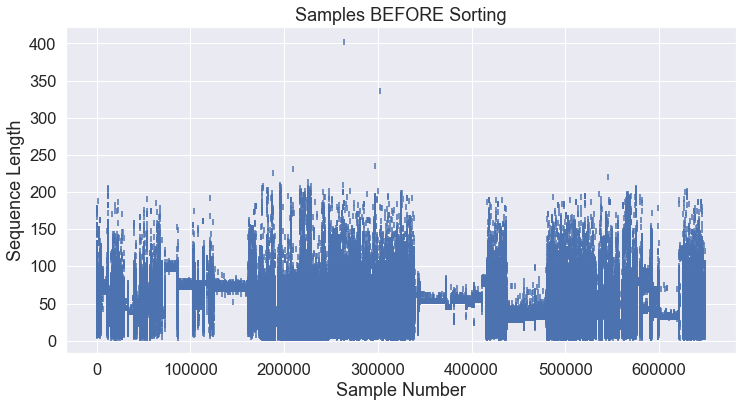

<Figure size 864x432 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

unsorted_lengths = [len(x) for x in full_input_ids]

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.savefig('/home/vrpo/SORTED.png', dpi = 500)
plt.show()
plt.draw()

In [9]:
sorted_samples = sorted(full_input_ids, key=lambda x: len(x))
print('Shortest sample:', len(sorted_samples[0]), ' <> Longest sample:', len(sorted_samples[-1]))

Shortest sample: 3  <> Longest sample: 402


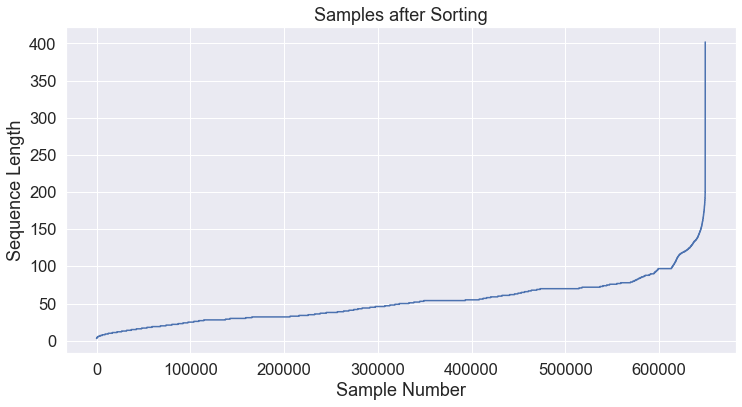

<Figure size 864x432 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_lengths = [len(s) for s in sorted_samples]

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.savefig('/home/vrpo/SORTED.png', dpi = 500)
plt.show()
plt.draw()

# Smart Batching

In [11]:
(py_inputs, py_attn_masks, py_ids) = make_smart_batches(tweets.clean_text, tweets.id, 250, 250)

Creating Smart Batches from 649,323 examples with batch size 250...

Tokenizing 649,323 samples...
  Tokenized 0 samples.
  Tokenized 60,000 samples.
  Tokenized 120,000 samples.
  Tokenized 180,000 samples.
  Tokenized 240,000 samples.
  Tokenized 300,000 samples.
  Tokenized 360,000 samples.
  Tokenized 420,000 samples.
  Tokenized 480,000 samples.
  Tokenized 540,000 samples.
  Tokenized 600,000 samples.
DONE.
   649,323 samples

   649,323 samples after sorting

Creating batches of size 250...

  DONE - Selected 2,598 batches.

Padding out sequences within each batch...
  DONE.


In [20]:
print('Extracting features for {:,} tweets...'.format(len(tweets.id)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# For each batch of training data...
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Calculate the time remaining based on our progress.
        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Copy the batch to the GPU.
    b_input_ids  = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)

    # Telling the model not to compute or store gradients, saving memory and speeding up the feed forward;
    with torch.no_grad():
        last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)
    batch_results = pd.DataFrame(last_hidden_states[0][:,0,:].cpu().numpy()); batch_results["id"] = py_ids[step];

    batch_results.to_csv(os.getcwd()[:os.getcwd().index("SENTICOIN")] + "/SENTICOIN/data/processed/models/regression/loader/vectors/BERT/batches/BATCH_" + str(step) + ".csv", index=False);
print('    DONE.')

Extracting features for 649,323 tweets...
  Batch     300  of    2,598.    Elapsed: 0:04:02.  Remaining: 0:30:50
  Batch     600  of    2,598.    Elapsed: 0:10:52.  Remaining: 0:36:12
  Batch     900  of    2,598.    Elapsed: 0:18:36.  Remaining: 0:35:06
  Batch   1,200  of    2,598.    Elapsed: 0:27:41.  Remaining: 0:32:15
  Batch   1,500  of    2,598.    Elapsed: 0:38:50.  Remaining: 0:28:26
  Batch   1,800  of    2,598.    Elapsed: 0:51:22.  Remaining: 0:22:46
  Batch   2,100  of    2,598.    Elapsed: 1:30:26.  Remaining: 0:21:27
  Batch   2,400  of    2,598.    Elapsed: 2:18:11.  Remaining: 0:11:24


RuntimeError: CUDA out of memory. Tried to allocate 446.00 MiB (GPU 0; 3.82 GiB total capacity; 1.27 GiB already allocated; 217.50 MiB free; 2.51 GiB reserved in total by PyTorch)

In [ ]:
# Decreasing the last size of the last 20 batches..
for step in range(2581, len(py_inputs)):

    for split in list(range(1, 6)):

        start = 0; end = 50;
        b_small_input_ids = py_inputs[step][start:end].to(device)
        b_small_input_mask = py_attn_masks[step][start:end].to(device)

        with torch.no_grad():
            last_hidden_states = model(b_small_input_ids, attention_mask=b_small_input_mask)
        batch_results = pd.DataFrame(last_hidden_states[0][:,0,:].cpu().numpy()); batch_results["id"] = py_ids[step][start:end];

        batch_results.to_csv(os.getcwd()[:os.getcwd().index("SENTICOIN")] + "/SENTICOIN/data/processed/models/regression/loader/vectors/BERT/batches/BATCH_" + str(step) + "_" + str(split) + ".csv", index=False);

        start = start + 50; end = end + 50;